<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_6_face_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [0]:
%tensorflow_version 2.x

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

##Загрузка датасета LFW

In [0]:
train_ds, ds_info = tfds.load(
    'lfw',
    as_supervised=True,
    with_info=True,
    split='train',
)

In [0]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

Label: b'Tom_Amstutz'


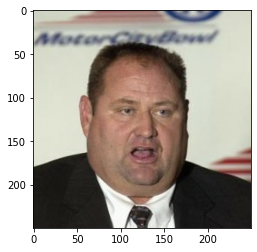

In [0]:
for example in train_ds.take(1):  # Only take a single example
    image, label = example[1], example[0]

    plt.imshow(image.numpy().astype(np.float32)/255)
    print(f"Label: {label}")

In [0]:
for i,j in enumerate(train_ds):
    if i < 3:
        print(i, j)
    else:
        break

0 (<tf.Tensor: shape=(), dtype=string, numpy=b'Tom_Amstutz'>, <tf.Tensor: shape=(250, 250, 3), dtype=uint8, numpy=
array([[[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       [[207, 209, 195],
        [207, 209, 195],
        [208, 210, 196],
        ...,
        [215, 218, 201],
        [215, 218, 201],
        [215, 218, 201]],

       ...,

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 24,  22,  23],
        [ 23,  21,  22],
        [ 23,  21,  22]],

       [[ 30,  29,  25],
        [ 29,  28,  24],
        [ 29,  28,  24],
        ...,
        [ 27,  25,  26],
        [ 25,  23,  24],
        [ 24,  22,  23]],

       [[ 30,  29,  25],
        [ 29,  28,  24

##Создание модели CNN

In [0]:
EMB_SIZE = 250

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

##Contrastive Loss

In [0]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

##Подготовка пайплайна данных

In [0]:
def normalize_example(label, image):
    return label, tf.cast(image, tf.float32) / 255.

In [0]:
BATCH_SIZE = 64
NUM_EPOCHS = 10

train_ds = train_ds.map(normalize_example)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [0]:
train_ds

<DatasetV1Adapter shapes: ((None,), (None, 250, 250, 3)), types: (tf.string, tf.float32)>

##Визуализация датасета

In [0]:
some_sample = next(iter(train_ds))
images = some_sample[1].numpy()[:4]
labels = some_sample[0].numpy()[:4]

In [0]:
labels

array([b'Jennifer_Garner', b'Catherine_Deneuve', b'Donald_Rumsfeld',
       b'Raul_Chacon'], dtype=object)

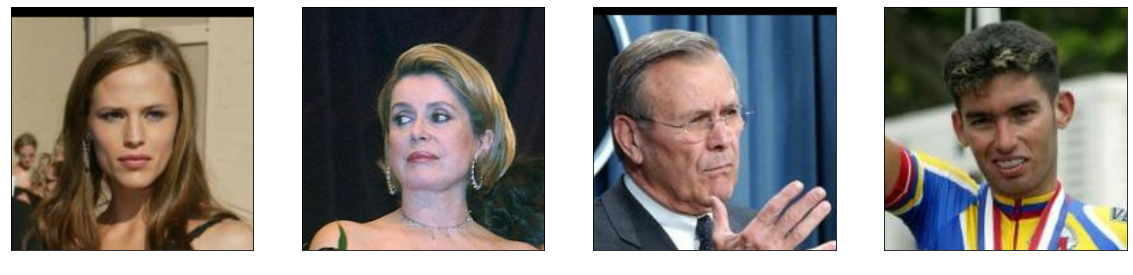

In [0]:
fontdict = {'fontsize': '14', 'color': 'white'}
plt.figure(figsize=(20,10))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images[i].reshape(250,250,3))
    plt.xlabel(labels[i].decode(), fontdict=fontdict)
plt.show()

##Подготовка к обучению

In [0]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

##Обучение модели

In [0]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 200 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 93.76286315917969
[200] Loss: 0.0
[400] Loss: 0.0037228278815746307
[600] Loss: 2.510343313217163
[800] Loss: 0.004869202151894569
[1000] Loss: 0.00034285924630239606
[1200] Loss: 0.0
[1400] Loss: 0.0
[1600] Loss: 0.0
[1800] Loss: 14.592707633972168
[2000] Loss: 0.7047129273414612
CPU times: user 9min 48s, sys: 4min 57s, total: 14min 46s
Wall time: 18min 41s


##Тестирование на новых данных

In [0]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250, 3), mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('George_W_Bush_1.jpeg')
img_a2 = load_and_prepare_image('George_W_Bush_2.jpg')
img_b = load_and_prepare_image('Mariangel_Ruiz_Torrealba.jpg')
img_c = load_and_prepare_image('Sally_Field.jpg')

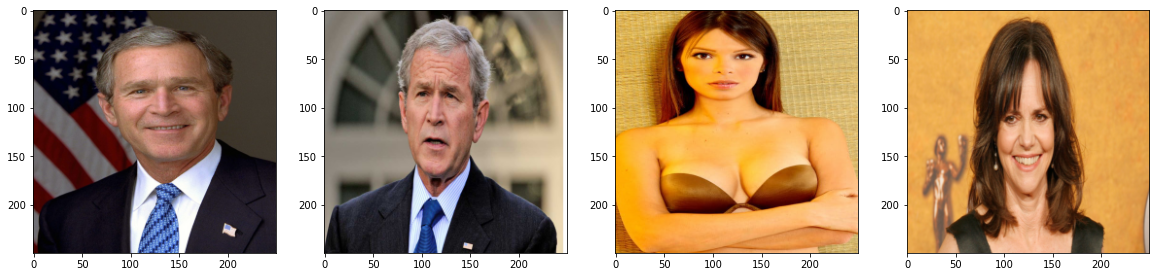

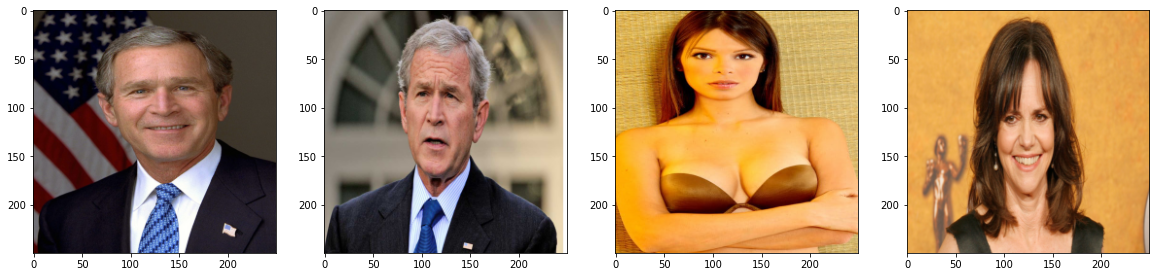

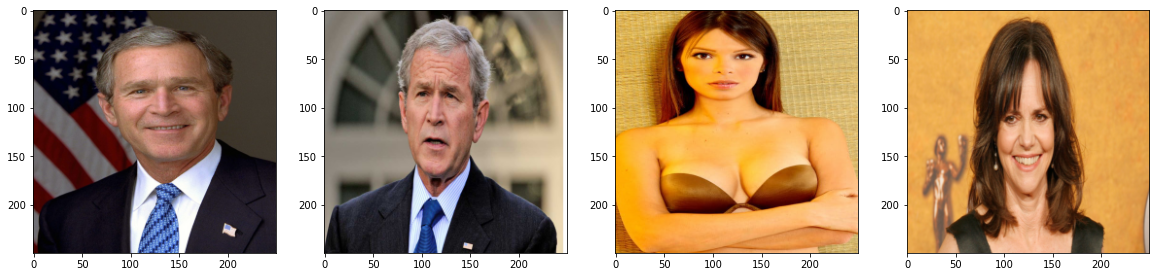

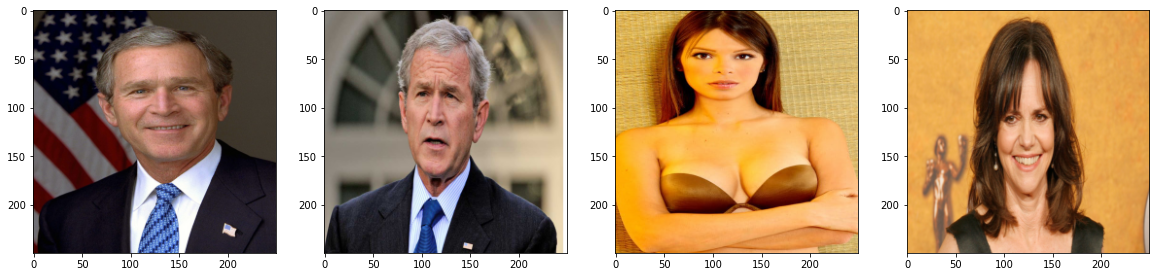

In [0]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 4)
ax.imshow(img_c)
plt.show()

##Получение эмбеддингов для новых данных

In [0]:
new_embs = model(np.stack((img_a1, img_a2, img_b, img_c), axis=0))

##Вычисление расстояний между эмбеддингами

In [0]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:] #George_W_Bush
emb2 = new_embs[1,:] #George_W_Bush
emb3 = new_embs[2,:] #Mariangel_Ruiz_Torrealba
emb4 = new_embs[3,:] #Sally_Field

print('George_W_Bush <-> George_W_Bush: ', diff(emb1, emb2))
print('George_W_Bush <-> Mariangel_Ruiz_Torrealba: ', diff(emb2, emb3))
print('George_W_Bush <-> Mariangel_Ruiz_Torrealba: ', diff(emb1, emb3))
print('George_W_Bush <-> Sally_Field: ', diff(emb1, emb4))
print('George_W_Bush <-> Sally_Field: ', diff(emb2, emb4))

George_W_Bush <-> George_W_Bush:  9.775475500692968
George_W_Bush <-> Mariangel_Ruiz_Torrealba:  26.95072113374531
George_W_Bush <-> Mariangel_Ruiz_Torrealba:  28.068086947328855
George_W_Bush <-> Sally_Field:  19.619716054434647
George_W_Bush <-> Sally_Field:  17.303964431846065


##Получение эмбеддингов для картинок из трейна

In [0]:
train_embs = model(images)

In [0]:
train_emb1 = train_embs[0,:] #Jennifer_Garner
train_emb2 = train_embs[1,:] #Catherine_Deneuve
train_emb3 = train_embs[2,:] #Donald_Rumsfeld
train_emb4 = train_embs[3,:]

In [0]:
img_a = load_and_prepare_image('Jennifer_Garner.jpg')
img_b = load_and_prepare_image('Catherine_Deneuve.jpg')
img_c = load_and_prepare_image('Donald_Rumsfeld.jpg')

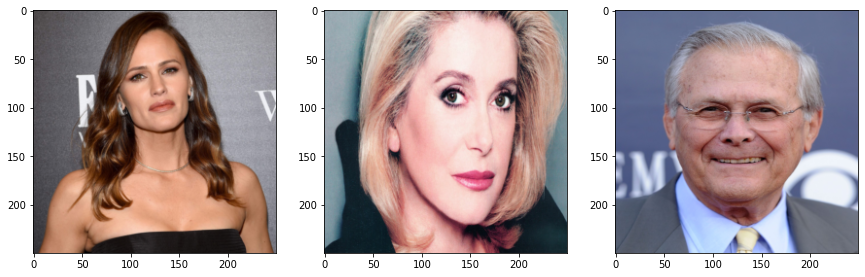

In [0]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 4, 1)
ax.imshow(img_a)
ax = fig.add_subplot(1, 4, 2)
ax.imshow(img_b)
ax = fig.add_subplot(1, 4, 3)
ax.imshow(img_c)
plt.show()

In [0]:
embs = model(np.stack((img_a, img_b, img_c), axis=0))

emb1 = embs[0,:] #Jennifer_Garner
emb2 = embs[1,:] #Catherine_Deneuve
emb3 = embs[2,:] #Donald_Rumsfeld

In [0]:
print('Jennifer_Garner <-> Jennifer_Garner_train: ', diff(emb1, train_emb1))
print('Catherine_Deneuve <-> Catherine_Deneuve_train: ', diff(emb2, train_emb2))
print('Donald_Rumsfeld <-> Donald_Rumsfeld: ', diff(emb3, train_emb3))

Jennifer_Garner <-> Jennifer_Garner_train:  12.51985910257149
Catherine_Deneuve <-> Catherine_Deneuve_train:  17.818503990870173
Donald_Rumsfeld <-> Donald_Rumsfeld:  25.074059006443168
